## Unequal Game solution with CCEM method

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Calculating optimal guaranteed results

Let's find guaranteed results


Definitions

\begin{gather*}
\Gamma^u = \min_{u(\cdot)}\max_{v(\cdot)} \gamma(u,\, v), \quad 
\Gamma^v = \max_{v(\cdot)}\min_{u(\cdot)} \gamma(u,\, v), \\
\tilde{\Gamma}^u = \min_{u(\cdot,\, \cdot)}\max_{v(\cdot,\, \cdot)} \gamma(u, v), \quad 
\tilde{\Gamma}^v = \max_{v(\cdot,\, \cdot)}\min_{u(\cdot,\, \cdot)} \gamma(u, v), \\\\
\Gamma^v \leqslant \tilde{\Gamma}^v \leqslant  \tilde{\Gamma}^v \leqslant \Gamma^u.
\end{gather*}

Our differential game model

\begin{gather*}
\begin{cases}
\dot{x} = u(t,\,x) - v(t,\,x), \quad t \in [0, 2],\\
x(0) = 1, \\
|u| \leqslant 2, \quad |v| \leqslant 1.
\end{cases}, \\ \\
\gamma(u,\, v) = x^2(2) = \left(1 + \int\limits_0^2 u(t, x)\,dt - \int\limits_0^2 v(t, x)\,dt \right)^2 = (1 +U(x) + V(x))^2, \\|U| \leqslant 4, \quad |V| \leqslant 2, \\ \\
\Gamma^u = 4, \quad \Gamma^v = \tilde{\Gamma}^v = \tilde{\Gamma}^v = 0.
\end{gather*}

Compute $\Gamma^u$

\begin{gather*}
\max_V \gamma(U,\, V) = \max\left\{\gamma(U,\, 2),\, \gamma(U,\, -2)\right\}, \\ \\
\gamma(U, 2) - \gamma(U, -2) = -8(1+U).
\end{gather*}

Case 1:
\begin{gather*}
\max_V \gamma(U,\, V) = \gamma(U,\, 2) \; \Longrightarrow \; U \leqslant -1 \; \Longrightarrow \; \Gamma^u = \min_U \gamma(U\,2) = \gamma(-1, 2) = 4.
\end{gather*}

Case 2:
\begin{gather*}
\max_V \gamma(U,\, V) = \gamma(U,\, -2) \; \Longrightarrow \; U \geqslant -1 \; \Longrightarrow \; \Gamma^u = \min_U \gamma(U\,-2) = \gamma(-1, -2) = 4.
\end{gather*}


Compute $\Gamma^v$

\begin{gather*}
\frac{\partial}{\partial U} \gamma(U,\,V) = 2(1 + U - V) = 0 \;\Longrightarrow\; U = V - 1 \Longrightarrow\; \Gamma^v = \max_{V}\gamma(V-1,\,V) = 0
\end{gather*}

Compute $\tilde{\Gamma}^u$

\begin{gather*}
\forall U, V \quad \tilde{\Gamma}^u \geqslant 0, \\ \\
U(x) = - 4 \cdot \text{sign}(x) \;\Longrightarrow\; \gamma(U,\, V) = \max_{V}(1 - 4 \cdot \text{sign}(x) - V(x))^2
\end{gather*}

Compute $\tilde{\Gamma}^v$

\begin{gather*}
0 = \Gamma^v \leqslant \tilde{\Gamma}^v \leqslant \tilde{\Gamma}^u = 0 \; \Longrightarrow \; \tilde{\Gamma}^v = 0.
\end{gather*}

# Code implementation

## Implement environment

In [130]:
class UnequalGame:
    """Unequal game environment implementation for RL practise"""

    def __init__(self, initial_x=1, dt=0.04, terminal_time=2, u_action_max=2, v_action_max=1):
        """Create an environment
        :param initial_x: starting point for u_agent
        :param dt: time rate
        :param terminal_time: stopping time
        :param u_action_max: maximum action value for u_agent
        :param v_action_max: maximum action value for v_agent
        """
        self.u_action_max = u_action_max
        self.v_action_max = v_action_max
        self.terminal_time = terminal_time
        self.dt = dt
        self.initial_x = initial_x
        self.state = self.reset()

    def reset(self):
        """Reset environment state for a new game session
        :return: starting state
        """
        self.state = np.array([0, self.initial_x])
        return self.state

    def step(self, u_action, v_action):
        """Generate a new environment state under the actions of agents
        :param u_action: u_agent action
        :param v_action: v_agent action
        :return: new state, reward, done flag, None
        """
        t, x = self.state
        x = x + (u_action - v_action) * self.dt
        t += self.dt
        self.state = np.array([t, x])

        reward = 0
        done = False
        if t >= self.terminal_time:
            reward = x ** 2
            done = True

        return self.state, reward, done, None


## Implement agent

In [131]:
class Network(torch.nn.Module):
    """Neural network for an agent"""

    def __init__(self, input_shape, output_shape):
        """Create new network
        :param input_shape: input data shape
        :param output_shape: output data shape
        """
        super().__init__()
        self.linear_1 = torch.nn.Linear(input_shape[0], 50)
        self.linear_2 = torch.nn.Linear(50, 30)
        self.linear_3 = torch.nn.Linear(30, output_shape[0])
        self.relu = torch.nn.ReLU()
        self.tang = torch.nn.Tanh()

    def forward(self, input_):
        """Network step
        :param input_: input data
        :return: network output result
        """
        hidden = self.relu(self.linear_1(input_))
        hidden = self.relu(self.linear_2(hidden))
        output = self.tang(self.linear_3(hidden))
        return output


class CCEMAgent(torch.nn.Module):
    """Continuous cross-entropy method agent implementation"""

    def __init__(self, state_shape, action_shape, action_max, reward_param=1, percentile_param=70, noise_decrease=0.98,
                 tau=1e-2, learning_rate=1e-2, n_learning_per_fit=16, mini_batch_size=200):
        """Create new agent
        :param state_shape: environment's state shape
        :param action_shape: agent's action shape
        :param action_max: maximum action value
        :param reward_param: equal to 1 if agent wants to maximize reward otherwise -1
        :param percentile_param: percentile to get elite sessions
        :param noise_decrease: noise decrease value
        :param tau: network weights updating rate
        :param learning_rate: learning rate for gradient descent method
        :param n_learning_per_fit: number of network updating weights iterations per fit
        """
        super().__init__()
        self.action_max = np.abs(action_max)
        self.reward_param = reward_param
        self.percentile_param = percentile_param
        self.noise_decrease = noise_decrease
        self.noise_threshold = 1
        self.min_noise_threshold = 0.1
        self.tau = tau
        self.n_learning_per_fit = n_learning_per_fit
        self.mini_batch_size = mini_batch_size
        self.network = Network(state_shape, action_shape)
        self.optimizer = torch.optim.Adam(params=self.network.parameters(), lr=learning_rate)

    def get_action(self, state, test=False):
        """Get an action by current state
        :param state: current environment state
        :param test: if True noise will not be added and will be otherwise
        :return: predicted action
        """
        state = torch.FloatTensor(state)
        predicted_action = self.network(state).detach().numpy() * self.action_max
        if not test:
            noise = self.noise_threshold * np.random.uniform(low=-self.action_max, high=self.action_max)
            predicted_action = np.clip(predicted_action + noise, -self.action_max, self.action_max)
        return predicted_action

    def get_elite_states_and_actions(self, sessions):
        """Select sessions with the most or least reward by percentile
        :param sessions: list of sessions to choose elite ones from
        :return: elite states, elite actions
        """
        total_rewards = [session['total_reward'] for session in sessions]
        reward_threshold = np.percentile(total_rewards, self.percentile_param)
        
        elite_states = []
        elite_actions = []
        for session in sessions:
            if self.reward_param * (session['total_reward'] - reward_threshold) > 0:
                elite_states.extend(session['states'])
                elite_actions.extend(session[f'{self}actions'])

        return torch.FloatTensor(elite_states), torch.FloatTensor(elite_actions)

    def learn_network(self, loss):
        """Update network weights by optimize loss
        :param loss: loss function to optimize
        :return: None
        """
        self.optimizer.zero_grad()
        old_network = deepcopy(self.network)
        loss.backward()
        self.optimizer.step()

        for new_parameter, old_parameter in zip(self.network.parameters(), old_network.parameters()):
            new_parameter.data.copy_(self.tau * new_parameter + (1 - self.tau) * old_parameter)

        return None

    def fit(self, sessions):
        """Fitting process using mini-batches
        :param sessions: sessions to fit on
        :return: None
        """
        elite_states, elite_actions = self.get_elite_states_and_actions(sessions)

        for _ in range(self.n_learning_per_fit):
            mini_batch_idxs = np.random.choice(range(elite_states.shape[0]), size=self.mini_batch_size)
            mini_batch_states = elite_states[mini_batch_idxs]
            mini_batch_actions = elite_actions[mini_batch_idxs]

            predicted_action = self.network(mini_batch_states) * self.action_max
            loss = torch.mean((predicted_action - mini_batch_actions) ** 2)
            self.learn_network(loss)

        if self.noise_threshold > self.min_noise_threshold:
            self.noise_threshold *= self.noise_decrease

        return None

    def __str__(self):
        """An agent string representation to define if it is u_agent or v_agent
        :return: string representation
        """
        return 'u_' if self.reward_param == -1 else 'v_'


## Generate sessions

In [132]:
def generate_session(first_agent, second_agent, env, test=False):
    """Generate session on environment with agents
    :param first_agent: first agent (u_agent by default)
    :param second_agent: second agent (v_agent by default)
    :param env: environment
    :param test: if True first agent will not add noise in get_action method
    :return: session dict wit states, first agent actions, second agent actions and total rewards
    """
    states = []
    first_agent_actions = []
    second_agent_actions = []
    total_reward = 0
    done = False
    state = env.reset()
    while not done:
        first_agent_action = first_agent.get_action(state, test=test)
        second_agent_action = second_agent.get_action(state)
        actions = (first_agent_action[0], second_agent_action[0]) if str(first_agent) == 'u_' else (second_agent_action[0], first_agent_action[0])
        next_state, reward, done, _ = env.step(*actions)
        states.append(state)
        first_agent_actions.append(first_agent_action)
        second_agent_actions.append(second_agent_action)
        total_reward += reward
        state = next_state

    return {'states': states,
            f'{first_agent}actions': first_agent_actions,
            f'{second_agent}actions': second_agent_actions,
            'total_reward': total_reward}



## Fit one epoch

In [133]:
def fit_epoch(u_agent, v_agent, env, n_sessions, test):
    """Fit agents during an one epoch
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_sessions: number of sessions
    :param test: if True u_agent will not be fitted
    :return: mean reward over sessions
    """
    sessions = [generate_session(u_agent, v_agent, env, test=test) for _ in range(n_sessions)]
    mean_reward = np.mean([session['total_reward'] for session in sessions])
    if not test:
        u_agent.fit(sessions)
    v_agent.fit(sessions)
    return mean_reward
    

## Test agents

In [134]:
def test_agent(u_agent, env, n_epochs, n_sessions, epsilon):
    """Test u_agent by fit a new v_agent
    :param u_agent: agent to test (must be u_agent type)
    :param env: environment
    :param n_epochs: number of epochs to fit
    :param n_sessions: number of sessions for one epoch
    :param epsilon: early stopping criterion (-1 to use all epochs)
    :return: test rewards
    """
    v_agent = CCEMAgent((2,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)
    _, rewards, _ = fit_agents(u_agent, v_agent, env, n_epochs, n_sessions, epsilon, test=True)
    return rewards


## Fit agents

In [135]:
def fit_agents(u_agent, v_agent, env, n_epochs, n_sessions,
               epsilon, n_iter_debug=0, test=False):
    """Fit both agent together during several epochs
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_epochs: number of epochs to fit
    :param n_sessions: number of sessions for one epoch
    :param epsilon: early stopping criterion (-1 to use all epochs)
    :param n_iter_debug: number of iteration between tests
    :param test: if True u_agent will not be fitted
    :return: u_agent, mean rewards, test rewards
    """
    last_mean_reward = 0
    mean_rewards = []
    test_rewards = []
    epoch = 0

    while epoch < n_epochs:

        mean_reward = fit_epoch(u_agent, v_agent, env, n_sessions=n_sessions, test=test)
        mean_rewards.append(mean_reward)
        print(f'epoch: {epoch}, mean reward: {mean_reward}')
        if np.abs(last_mean_reward - mean_reward) < epsilon:
            break
        last_mean_reward = mean_reward
        epoch += 1

        if n_iter_debug and (epoch + 1) % n_iter_debug == 0:
            print('\n{:-^50}\n'.format('TEST BEGIN'))
            test_rewards.append(test_agent(u_agent, env, n_epochs=50, n_sessions=n_sessions, epsilon=epsilon))
            print('\n{:-^50}\n'.format('TEST END'))        

    return u_agent, np.array(mean_rewards), np.array(test_rewards)


## Fit agents one by one

In [136]:
def fit_agents_one_by_one(u_agent, v_agent, env, n_epochs, n_sessions,
                          n_iter_for_fit, epsilon, n_iter_debug=0):
    """Fit agents ony by one during several epochs.
    During fix number of iterations one agent will be fitted while the other will not.
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_epochs: number of epochs to fit
    :param n_sessions: number of sessions for one epoch
    :param n_iter_for_fit: number of iterations between agent switching
    :param epsilon: early stopping criterion (-1 to use all epochs)
    :param n_iter_debug: number of iteration between tests
    :return: u_agent, mean rewards, test rewards
    """
    last_mean_reward = 0
    mean_rewards = []
    test_rewards = []
    fit_agent = u_agent
    wait_agent = v_agent
    epoch = 0
    stop = False

    while not stop and epoch < n_epochs:

        for _ in range(n_iter_for_fit):
            
            mean_reward = fit_epoch(wait_agent, fit_agent, env, n_sessions, test=True)
            mean_rewards.append(mean_reward)
            print(f'epoch: {epoch}, current agent: {fit_agent}, mean reward: {mean_reward}')
            if np.abs(last_mean_reward - mean_reward) < epsilon:
                stop = True
                break
            last_mean_reward = mean_reward
            epoch += 1
            if epoch >= n_epochs:
                break

            if n_iter_debug and (epoch + 1) % n_iter_debug == 0:
                print('\n{:-^50}\n'.format('TEST BEGIN'))
                test_rewards.append(test_agent(u_agent, env, n_epochs=50, n_sessions=n_sessions, epsilon=epsilon))
                print('\n{:-^50}\n'.format('TEST END'))    

        print('\n')
        wait_agent, fit_agent = fit_agent, wait_agent

    return u_agent, np.array(mean_rewards), np.array(test_rewards)


## Fit random agent pairs

In [137]:
def fit_random_agent_pairs(u_agents, v_agents, env, n_pairs, n_epochs, n_sessions, n_iter_debug=0):
    """ Fit random pairs of u_ and v_agents
    :param u_agent: agent that wants to minimize reward
    :param v_agent: agent that wants to maximize reward
    :param env: environment
    :param n_pairs: number of pairs to fit
    :param n_epochs: number of epochs for one pair fit
    :param n_sessions: number of sessions for one epoch
    :param n_iter_debug: number of iteration between tests
    :return: u_agent that will have overall minimum total reward, mean rewards for u_agents
    """
    u_agents_mean_rewards = [[] for _ in range(len(u_agents))]

    for i in range(n_pairs):
        u_agent_idx = np.random.choice(len(u_agents))
        v_agent_idx = np.random.choice(len(v_agents))
        print(f'PAIR {i + 1} OF {n_pairs}')
        print('\n{:-^50}\n'.format(f'U_AGENT_{u_agent_idx} VS V_AGENT_{v_agent_idx}'))
        _, mean_rewards, _ = fit_agents(u_agents[u_agent_idx], v_agents[v_agent_idx],
                                        env=env, n_epochs=n_epochs, n_sessions=n_sessions,
                                        epsilon=-1, n_iter_debug=n_iter_debug)
        print('\n{:-^50}\n'.format(''))

        u_agents_mean_rewards[u_agent_idx].append(mean_rewards.min())

    best_u_agent_idx = np.argmin([np.min(lst) if lst else float('inf') for lst in u_agents_mean_rewards])
    print(f'\nBest agent is {best_u_agent_idx}, its best reward is {np.min(u_agents_mean_rewards[best_u_agent_idx])}\n')
    return u_agents[best_u_agent_idx], u_agents_mean_rewards



## Plot mean rewards by epochs

In [138]:
def plot_mean_rewards(mean_rewards, method_name, test_rewards=None):
    """Plot mean rewards
    :param mean_rewards: rewards to plot
    :param method_name: fitting method name
    :param test_rewards: test rewards to plot
    """
    if test_rewards is not None:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        _, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(range(len(mean_rewards)), mean_rewards)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('Mean reward')
    ax1.set_title(f'Mean rewards for {method_name} over epochs')
    ax1.grid()
    if test_rewards is not None:
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('Test reward')
        ax2.set_title(f'Test rewards for {method_name} over epochs')
        for i, test_reward in enumerate(test_rewards):
            ax2.plot(range(len(test_reward)), test_reward, label=f'Test {i}')
        ax2.legend()
        ax2.grid()
    plt.show()  

# Fitting

## Deafualt fit

In [139]:
env = UnequalGame()
u_agent = CCEMAgent((2,), (1,), percentile_param=10, action_max=env.u_action_max, reward_param=-1)
v_agent = CCEMAgent((2,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)

In [117]:
u_fit_agent, mean_rewards, test_rewards \
= fit_agents(u_agent, v_agent, env, n_epochs=200, n_sessions=100, epsilon=-1, n_iter_debug=40)

epoch: 0, mean reward: 2.7516918177655665
epoch: 1, mean reward: 2.6219299853120135
epoch: 2, mean reward: 2.4242163546945084
epoch: 3, mean reward: 1.9606413178480104
epoch: 4, mean reward: 1.8055990913337823
epoch: 5, mean reward: 1.6284917636418286
epoch: 6, mean reward: 1.358139830836238
epoch: 7, mean reward: 1.1397005647140102
epoch: 8, mean reward: 1.050735437785139
epoch: 9, mean reward: 0.7990201235217244
epoch: 10, mean reward: 0.6525161642940719
epoch: 11, mean reward: 0.5217826768477812
epoch: 12, mean reward: 0.40282494094029475
epoch: 13, mean reward: 0.32203471229365893
epoch: 14, mean reward: 0.24517312810678604
epoch: 15, mean reward: 0.1593955806678172
epoch: 16, mean reward: 0.10681918949189428
epoch: 17, mean reward: 0.06922492128430899
epoch: 18, mean reward: 0.04706489213754624
epoch: 19, mean reward: 0.04880915005783638
epoch: 20, mean reward: 0.03354349263452067
epoch: 21, mean reward: 0.03825643069623346
epoch: 22, mean reward: 0.03237515454171142
epoch: 23, me

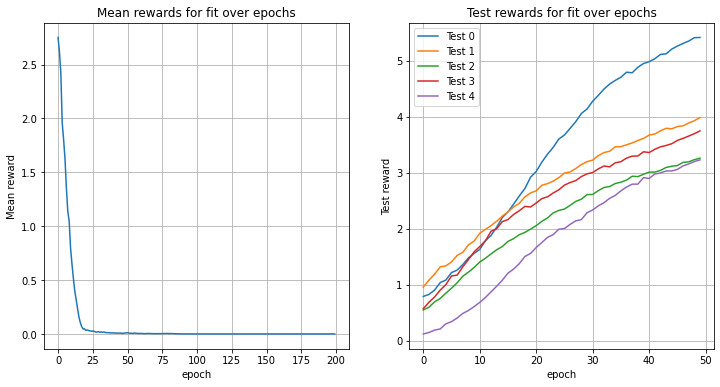

In [118]:
plot_mean_rewards(mean_rewards, method_name='fit', test_rewards=test_rewards)

## Fit one by one

In [119]:
u_agent_one_by_one = CCEMAgent((2,), (1,), percentile_param=10, action_max=env.u_action_max, reward_param=-1)
v_agent_one_by_one = CCEMAgent((2,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)

In [120]:
u_fit_agent_one_by_one, mean_rewards_one_by_one, test_rewards_one_by_one =\
fit_agents_one_by_one(u_agent_one_by_one, v_agent_one_by_one, env, \
                       n_epochs=400, n_sessions=100, n_iter_for_fit=20, epsilon=-1, n_iter_debug=80)

epoch: 0, current agent: u_, mean reward: 1.600345868333902
epoch: 1, current agent: u_, mean reward: 1.241041170911282
epoch: 2, current agent: u_, mean reward: 0.6955289482305758
epoch: 3, current agent: u_, mean reward: 0.499661003487889
epoch: 4, current agent: u_, mean reward: 0.2647872218404943
epoch: 5, current agent: u_, mean reward: 0.18074042187434103
epoch: 6, current agent: u_, mean reward: 0.10324746071723444
epoch: 7, current agent: u_, mean reward: 0.05764917489965204
epoch: 8, current agent: u_, mean reward: 0.039748735571570326
epoch: 9, current agent: u_, mean reward: 0.040480045205744844
epoch: 10, current agent: u_, mean reward: 0.030951904210645025
epoch: 11, current agent: u_, mean reward: 0.024941253232568353
epoch: 12, current agent: u_, mean reward: 0.026216569627500883
epoch: 13, current agent: u_, mean reward: 0.027656882439396843
epoch: 14, current agent: u_, mean reward: 0.02553783214232148
epoch: 15, current agent: u_, mean reward: 0.023781588954342812
epo

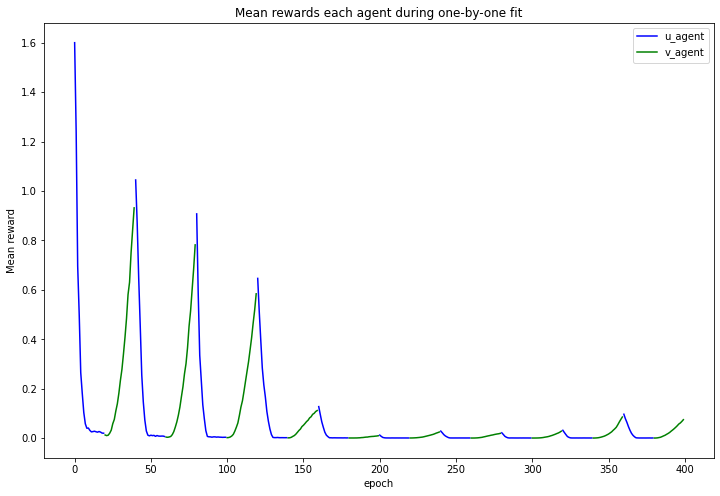

In [121]:
_, ax = plt.subplots(figsize=(12, 8))
c = 'b'
l = 0
for rewards in np.array_split(mean_rewards_one_by_one, 20):
    ax.plot(range(l, l + len(rewards)), rewards, color=c)
    l = l + len(rewards)
    c = 'b' if c=='g' else 'g'
    ax.set_xlabel('epoch')
    ax.set_ylabel('Mean reward')
    ax.set_title(f'Mean rewards each agent during one-by-one fit')
    ax.legend(labels=['u_agent', 'v_agent'])
    ax.grid()
plt.show()

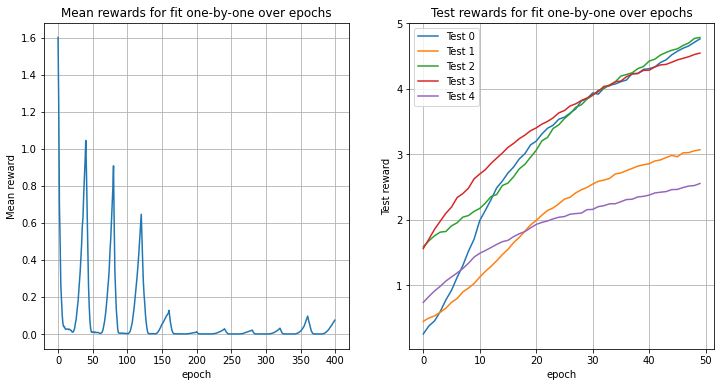

In [122]:
plot_mean_rewards(mean_rewards_one_by_one, method_name='fit one-by-one', test_rewards=test_rewards_one_by_one)

## Fit random pairs

In [148]:
u_agents = [CCEMAgent((2,), (1,), percentile_param=10, action_max=env.u_action_max, reward_param=-1)\
            for _ in range(5)]
v_agents = [CCEMAgent((2,), (1,), percentile_param=90, action_max=env.v_action_max, reward_param=1)\
            for _ in range(5)]

In [149]:
u_fit_random_agent, mean_rewards_random = fit_random_agent_pairs(u_agents, v_agents, env,\
                                                                 n_pairs=30, n_epochs=30, n_sessions=100, n_iter_debug=0)

PAIR 1 OF 30

--------------U_AGENT_0 VS V_AGENT_1--------------

epoch: 0, mean reward: 0.10691050153929299
epoch: 1, mean reward: 0.11821585336072576
epoch: 2, mean reward: 0.11516568447333997
epoch: 3, mean reward: 0.09730084501688248
epoch: 4, mean reward: 0.10576524603595988
epoch: 5, mean reward: 0.1065937695291263
epoch: 6, mean reward: 0.11724253044377651
epoch: 7, mean reward: 0.10561067888037606
epoch: 8, mean reward: 0.09290536245592593
epoch: 9, mean reward: 0.0769215501801201
epoch: 10, mean reward: 0.09979407464669877
epoch: 11, mean reward: 0.07526007560751735
epoch: 12, mean reward: 0.06317501756978097
epoch: 13, mean reward: 0.08211580471155866
epoch: 14, mean reward: 0.045435830605686116
epoch: 15, mean reward: 0.05741909560218779
epoch: 16, mean reward: 0.06486139998156662
epoch: 17, mean reward: 0.051059389905553074
epoch: 18, mean reward: 0.05733867008626556
epoch: 19, mean reward: 0.06537531660548565
epoch: 20, mean reward: 0.04875510727915107
epoch: 21, mean rewa

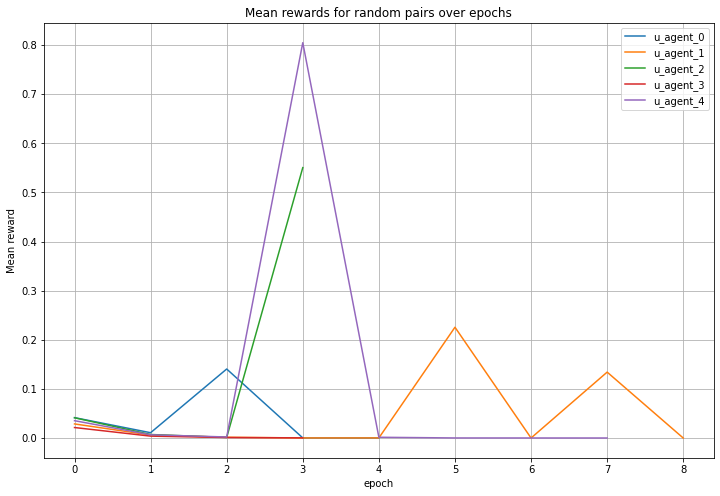

In [150]:
 _, ax = plt.subplots(figsize=(12, 8))

for i, rewards in enumerate(mean_rewards_random):
    ax.plot(range(len(rewards)), rewards, label=f'u_agent_{i}')

ax.set_xlabel('epoch')
ax.set_ylabel('Mean reward')
ax.set_title(f'Mean rewards for random pairs over epochs')
ax.grid()
ax.legend()
plt.show()

# Testing

## Test default u_agent

In [81]:
test_all_rewards = test_agent(u_fit_agent, env, n_epochs=300, n_sessions=100, epsilon=-1)

epoch: 0, mean reward: 0.9461004357794259
epoch: 1, mean reward: 1.0584743094262772
epoch: 2, mean reward: 1.1053535929212288
epoch: 3, mean reward: 1.236899632330915
epoch: 4, mean reward: 1.4500512111560766
epoch: 5, mean reward: 1.543212376595219
epoch: 6, mean reward: 1.8036095452298766
epoch: 7, mean reward: 1.9628035893496538
epoch: 8, mean reward: 2.2366061772498056
epoch: 9, mean reward: 2.493540976254887
epoch: 10, mean reward: 2.623709641718014
epoch: 11, mean reward: 2.816519060704315
epoch: 12, mean reward: 3.0142408502342035
epoch: 13, mean reward: 3.2471917973422375
epoch: 14, mean reward: 3.4344826709543446
epoch: 15, mean reward: 3.510185306573162
epoch: 16, mean reward: 3.733646881349147
epoch: 17, mean reward: 3.8537096742619035
epoch: 18, mean reward: 4.033116466460219
epoch: 19, mean reward: 4.10904560741289
epoch: 20, mean reward: 4.246945841716386
epoch: 21, mean reward: 4.421945276183205
epoch: 22, mean reward: 4.439259291162422
epoch: 23, mean reward: 4.58443536

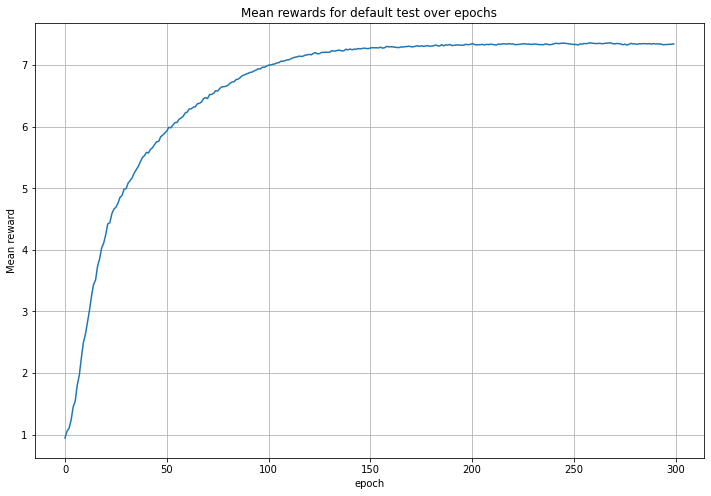

In [82]:
plot_mean_rewards(test_all_rewards, method_name='default test')

## Test u_agent_one_by_one

In [126]:
test_all_rewards_one_by_one = test_agent(u_fit_agent_one_by_one, env, n_epochs=300, n_sessions=100, epsilon=-1)

epoch: 0, mean reward: 1.0877396288395746
epoch: 1, mean reward: 1.147883631829625
epoch: 2, mean reward: 1.2214136563845797
epoch: 3, mean reward: 1.2991348168109678
epoch: 4, mean reward: 1.3548134136150312
epoch: 5, mean reward: 1.3964457242180066
epoch: 6, mean reward: 1.4696791615462328
epoch: 7, mean reward: 1.492050988302975
epoch: 8, mean reward: 1.5180746584216471
epoch: 9, mean reward: 1.5617113363106485
epoch: 10, mean reward: 1.6096186869157918
epoch: 11, mean reward: 1.626333559377182
epoch: 12, mean reward: 1.6969537055409283
epoch: 13, mean reward: 1.726008333818011
epoch: 14, mean reward: 1.7716052478891189
epoch: 15, mean reward: 1.787599442534754
epoch: 16, mean reward: 1.8443264018787684
epoch: 17, mean reward: 1.8892370509221508
epoch: 18, mean reward: 1.9320682329796082
epoch: 19, mean reward: 1.9480503488787986
epoch: 20, mean reward: 1.9699647541073708
epoch: 21, mean reward: 2.0291933393229034
epoch: 22, mean reward: 2.0206397757078727
epoch: 23, mean reward: 2.

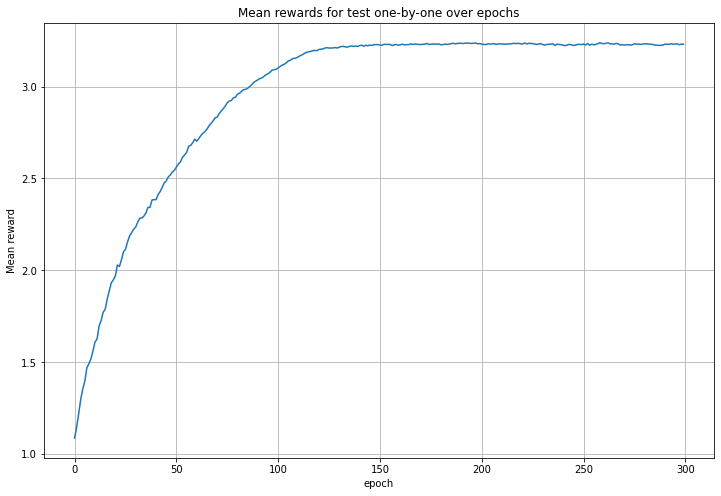

In [127]:
plot_mean_rewards(test_all_rewards_one_by_one, method_name='test one-by-one')

## Test u_agent_random

In [151]:
test_all_rewards_random = test_agent(u_fit_random_agent, env, n_epochs=300, n_sessions=100, epsilon=-1)

epoch: 0, mean reward: 0.11311638187597758
epoch: 1, mean reward: 0.1263994865995172
epoch: 2, mean reward: 0.14052862383694642
epoch: 3, mean reward: 0.1607357438217617
epoch: 4, mean reward: 0.17040667006622992
epoch: 5, mean reward: 0.1788499564082689
epoch: 6, mean reward: 0.19450500033713772
epoch: 7, mean reward: 0.19056553963666478
epoch: 8, mean reward: 0.20789339413892505
epoch: 9, mean reward: 0.21431877923722933
epoch: 10, mean reward: 0.2280841234047367
epoch: 11, mean reward: 0.2366784567733303
epoch: 12, mean reward: 0.25356709343710687
epoch: 13, mean reward: 0.2648924926097466
epoch: 14, mean reward: 0.2734455442633498
epoch: 15, mean reward: 0.282674710585485
epoch: 16, mean reward: 0.28894107822682835
epoch: 17, mean reward: 0.3013869098668058
epoch: 18, mean reward: 0.31063700603839167
epoch: 19, mean reward: 0.3223681029443474
epoch: 20, mean reward: 0.3230170433416766
epoch: 21, mean reward: 0.3201953556815009
epoch: 22, mean reward: 0.3282801588230598
epoch: 23, m

KeyboardInterrupt: ignored

In [ ]:
plot_mean_rewards(test_all_rewards_random, method_name='test random pairs')